

### Loading Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
import random

Link to Dataset:   
    *Images:* https://drive.google.com/file/d/1uvTYTSqhiuZ1ey9BADYvTT1EHC1waJKJ/view?usp=sharing    
    *Target output:* https://drive.google.com/file/d/1cgIjQ3lhpLphA48YexQ3rXEZp8WSYGDX/view?usp=sharing  

### Downloading the files and unzipping the dataset images:

In [ ]:
!gdown --id 1uvTYTSqhiuZ1ey9BADYvTT1EHC1waJKJ # images zip file 
!gdown --id 1cgIjQ3lhpLphA48YexQ3rXEZp8WSYGDX # csv file containing target values for each image

Downloading...
From: https://drive.google.com/uc?id=1uvTYTSqhiuZ1ey9BADYvTT1EHC1waJKJ
To: /content/images.zip
32.2MB [00:01, 21.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cgIjQ3lhpLphA48YexQ3rXEZp8WSYGDX
To: /content/emergency_train.csv
100% 19.0k/19.0k [00:00<00:00, 17.8MB/s]


In [ ]:
!unzip images.zip

Archive:  images.zip
  inflating: images/0.jpg            
  inflating: images/1.jpg            
  inflating: images/10.jpg           
  inflating: images/100.jpg          
  inflating: images/1000.jpg         
  inflating: images/1001.jpg         
  inflating: images/1002.jpg         
  inflating: images/1003.jpg         
  inflating: images/1004.jpg         
  inflating: images/1005.jpg         
  inflating: images/1006.jpg         
  inflating: images/1007.jpg         
  inflating: images/1008.jpg         
  inflating: images/1009.jpg         
  inflating: images/101.jpg          
  inflating: images/1010.jpg         
  inflating: images/1011.jpg         
  inflating: images/1012.jpg         
  inflating: images/1013.jpg         
  inflating: images/1014.jpg         
  inflating: images/1015.jpg         
  inflating: images/1016.jpg         
  inflating: images/1017.jpg         
  inflating: images/1018.jpg         
  inflating: images/1019.jpg         
  inflating: images/102.jpg  

### Observing the Dataset:

In [ ]:
traindf = pd.read_csv('emergency_train.csv',dtype = str)
traindf.head(10)

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
5,45.jpg,1
6,2313.jpg,0
7,1657.jpg,0
8,294.jpg,1
9,999.jpg,0


In [ ]:
tt = traindf.to_numpy()
tt[0]
for i in tt[0]:
    print(i)
for i,j in tt[5:9]:
    print(i,j)

1503.jpg
0
45.jpg 1
2313.jpg 0
1657.jpg 0
294.jpg 1


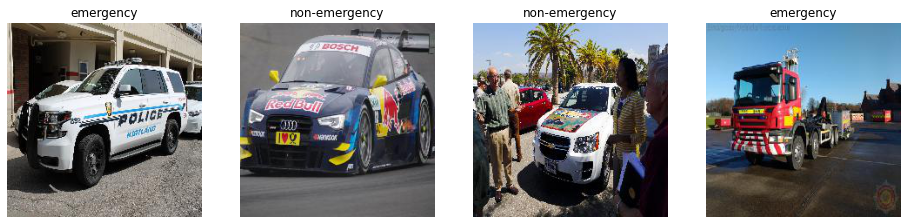

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.image as mpimg
import os
# observing input and output:
nrows = 1
ncols = 4
fig = plt.gcf() 
fig.set_size_inches(ncols*4, nrows*4)

label = pd.read_csv('emergency_train.csv',dtype = str)
label = label.to_numpy()
label = label[5:9]

k=0
for img,lbl in label:
    sp = plt.subplot(nrows, ncols, k+1) 
    sp.axis('Off') 
    img = mpimg.imread(os.path.join('/content/images',img))
    plt.imshow(img)
    k+=1
    if lbl == '1':
        sp.set_title('emergency')
    else:
        sp.set_title('non-emergency')
plt.show()

### Making DataGenerators:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.1)
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.15)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory='images',
    x_col = 'image_names',
    y_col = 'emergency_or_not',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224,224)
)

Found 1646 validated image filenames belonging to 2 classes.


In [ ]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory='images',
    x_col = 'image_names',
    y_col = 'emergency_or_not',
    subset = 'validation',
    batch_size = 16,
    seed = 42,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224,224)
)

Found 164 validated image filenames belonging to 2 classes.


In [ ]:
valid_gen = valid_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory='images',
    x_col = 'image_names',
    y_col = 'emergency_or_not',
    subset = 'validation',
    batch_size = 16,
    seed = 42,
    shuffle = True,
    class_mode = 'binary',
    target_size = (224,224)
)

Found 246 validated image filenames belonging to 2 classes.


### Loading Model and Training:

In [5]:
# Loading VGG16 model with image net weights:
vgg = VGG16(include_top=False, weights = 'imagenet', input_shape=(224,224,3)) 
# point to note that when you include_top i.e. the Fully connected neurons then you need the size as 224x224 
# for the pre-trained weights are for 224x224 in keras, when include_top is true then predictions making require
# FCN at end and FCN have fixed parameters fed from flatten layer so image size cannot be changed in this case

# opposite to FCN, a Convolution transfer has only the filters which convolved over the image gives different 
# learned features thus image size doesn't affect convolutional layer transfer, but effect the FCN for prediciton

# making the layers non-trainable:
for i in vgg.layers:
    i.trainable = False 
    # we could also have just written : vgg.trainable = False

x = Flatten()(vgg.output)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = vgg.input, outputs = x)
model.compile(loss='binary_crossentropy', optimizer = 'Adam', metrics=['accuracy'])

58892288/58889256 [==============================] - 0s 0us/step


In [3]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
train_gen.class_indices

{'0': 0, '1': 1}

In [ ]:
history = model.fit_generator(train_gen,epochs = 8, validation_data= valid_gen)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
52/52 [==============================] - 64s 516ms/step - loss: 0.7288 - accuracy: 0.6421 - val_loss: 0.2550 - val_accuracy: 0.9106
Epoch 2/8
52/52 [==============================] - 20s 378ms/step - loss: 0.2521 - accuracy: 0.8987 - val_loss: 0.1938 - val_accuracy: 0.9309
Epoch 3/8
52/52 [==============================] - 20s 379ms/step - loss: 0.1839 - accuracy: 0.9458 - val_loss: 0.1383 - val_accuracy: 0.9675
Epoch 4/8
52/52 [==============================] - 20s 380ms/step - loss: 0.1736 - accuracy: 0.9398 - val_loss: 0.1395 - val_accuracy: 0.9472
Epoch 5/8
52/52 [==============================] - 20s 382ms/step - loss: 0.1313 - accuracy: 0.9582 - val_loss: 0.0987 - val_accuracy: 0.9634
Epoch 6/8
52/52 [==============================] - 20s 378ms/step - loss: 0.1302 - accuracy: 0.9580 - val_loss: 0.1629 - val_accuracy: 0.9268
Epoch 7/8
52/52 [==============================] - 20s 377ms/step - loss: 0.1153 - accuracy: 0.9632 - val_loss: 0.0903 - val_accuracy: 0.9675
Epoch 

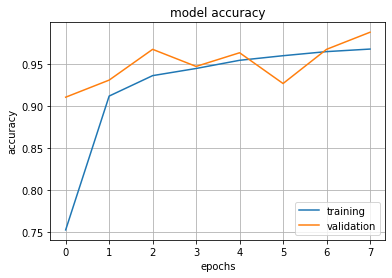

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc = 'best')
plt.grid('on')
plt.show()

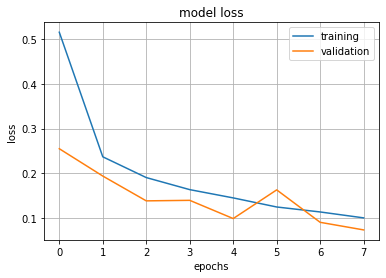

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc = 'best')
plt.grid('on')
plt.show()

In [ ]:
# Evaluating on test data:
loss, accuracy = model.evaluate(test_gen, steps = 50)
print('%s: %.2f%%'% (model.metrics_names[1], accuracy) )

50/50 [==============================] - 1s 12ms/step - loss: 0.0766 - accuracy: 0.9878
accuracy: 0.99%


Thus, We learned how to use pre-trained networks for Transfer Learning  
Refer to this article for Question related to Transfer Learn
https://datascience.stackexchange.com/questions/57639/transfer-learning-on-new-image-size